---

In [1]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch.utils.tensorboard import SummaryWriter

# 自定义模块
from torchLearning import *

# 导入以下包从而使得可以在jupyter中的一个cell输出多个结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### <center> 【Lesson 13 加餐】损失函数的随机创建现象详解

&emsp;&emsp;接下来，我们通过手动创建一个实例，来观察在小批梯度下降过程中，损失函数是如何根据数据数据变化而变化的，这里既是作为本节内容的一个补充，同时也是指出一个常见的误区、以及解决一个常见的问题。

<center><img src="https://i.loli.net/2021/01/23/caNAtMFI5dqhfH6.jpg" alt="11" style="zoom:30%;" />

- 误区：损失函数从始至终都不变，梯度下降迭代过程就是“从山顶走到山脚”，一步步找到最小值；
- 问题：为何迭代过程中损失函数下降，但模型评估指标却出现波动。

我们通过手动实例进行说明。首先创建一组数据如下：

|x|y|
| :------: | :------: |
| 1 | 2 |
| 3 | 5 |
| 6 | 4 |
| 8 | 3 |

我们使用$y=wx$方程对其进行拟合，并以SSE作为损失函数。假设我们使用小批量梯度下降，每次带入两条数据进行损失函数计算，第一次带入前两条数据、第二次带入后两条数据，则第一轮epoch的第一次迭代过程中损失函数如下：

$$ \begin{align} SSE_{(1)}
& = (2-1*w)^2 + (5-3*w)^2 \\
& = w^2-4w+4+9w^2-30w+25 \\
& = 10w^2-34w+29  \end{align} $$

据此可以算得当前梯度公式如下：

<center>$ \begin{align} 
grad_{(1)}
& = \frac{\partial{SSE_{(1)}}}{\partial{(w)}}  \\
& = 20w-34 \\ \end{align} $</center>

然后再进行迭代。然而再第一轮epoch的第二次迭代时，由于我们带入了另外两条数据，此时的损失函数就有所不同了：

$$ \begin{align} SSE_{(2)}
& = (4-6*w)^2 + (3-8*w)^2 \\
& = 36w^2-48w+16+64w^2-48w+9 \\
& = 100w^2-96w+25  \end{align} $$

对应的梯度计算公式也会有所不同

<center>$ \begin{align} 
grad_{(2)}
& = \frac{\partial{SSE_{(1)}}}{\partial{(w)}}  \\
& = 200w-96 \\ \end{align} $</center>

而此时如果我们以SSE作为模型评估指标，则模型评估指标其实是每一个“小批”数据对应损失函数之和：

$$ \begin{align} SSE
& = (2-1*w)^2 + (5-3*w)^2 + (4-6w)^2 + (3-8w)^2 \\
& = SSE_{(1)}+SSE_{(2)} \\
& = 110w^2-100w+54 \end{align} $$

迭代过程我们要求每一次迭代损失函数都降低，但通过观察上述过程不难发现，第一轮epoch迭代第一次时，$SSE_1$能够顺利降低，但$SSE_2$和$SSE$并不一定，同理，第一轮epoch迭代第二次时，$SSE_2$能够顺利降低，但$SSE_1$和$SSE$并不一定。虽然我们相信数据整体特性应该保持一致，大概率来说其中一个损失函数减少，其他损失函数也会减少，但毕竟方程不同，这其中确实也存在着一定的不确定性。我们可以通过以下代码进行实验。

In [2]:
# SSE1损失函数计算函数
def loss_sse1(x):
    loss1 = 10 * x * x - 34 * x + 29
    return loss1

# SSE2损失函数计算函数
def loss_sse2(x):
    loss2 = 100 * x * x - 96 * x + 25
    return loss2

# SSE损失函数计算函数
def loss_sse(x):
    loss = 110 * x * x - 100 * x + 54
    return loss

# SSE1的梯度计算函数
def g1(x):
    grad1 = 20 * x - 34
    return grad1

# SSE2的梯度计算函数
def g2(x):
    grad2 = 200 * x - 96
    return grad2

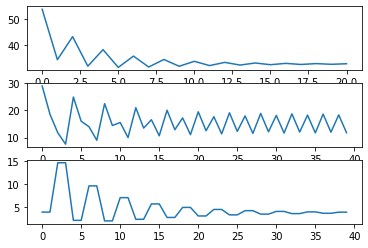

In [3]:
# 定义核心参数
w = 0                      # w的初始取值
lr = 0.01                  # 模型学习率
num_epochs = 20            # 迭代轮数

# 创建空列表容器
w_l = [0]                  # w迭代过程取值
loss_l = []                # 整体SSE取值
loss1_l = []               # SSE1取值
loss2_l = []               # SSE2取值


for i in range(num_epochs):
    loss_l.append(loss_sse(w))         # 每一轮迭代开始前计算整体SSE
    loss1_l.append(loss_sse1(w))       # 每一轮第一次迭代开始前计算SSE1
    w -= lr * g1(w)                    # 每一轮的第一次迭代
    w_l.append(w)                      # 每一轮第一次迭代后储存w
    loss1_l.append(loss_sse1(w))       # 每一轮第一次迭代后计算SSE1
    loss2_l.append(loss_sse2(w))       # 每一轮第二次迭代开始前计算SSE2
    w -= lr * g2(w)                    # 每一轮第二次迭代
    w_l.append(w)                      # 每一轮第二次迭代后储存w
    loss2_l.append(loss_sse2(w))       # 每一轮第二次迭代后计算SSE2

loss_l.append(loss_sse(w))             # 训练完成后存储最终w

# 绘图部分
# 查看整体SSE变化情况
plt.subplot(311)
plt.plot(list(range(num_epochs+1)), loss_l)
# 查看SSE1变化情况
plt.subplot(312)
plt.plot(list(range(num_epochs*2)), loss1_l)
# 查看SSE2变化情况
plt.subplot(313)
plt.plot(list(range(num_epochs*2)), loss2_l)

&emsp;&emsp;从上述结果能够看出，每一轮的内部两次迭代，对于SSE1和SSE2来说都是降低的，但每一轮之间SSE1和SSE2都会出现波动，原因也是因为其他的损失函数计算出来的w不一定能有效帮助当前损失函数降低取值，当然整体SSE也是在波动中趋于稳定的。由此我们就能够明白为何在模型训练过程中，明明应该“整体向好”，但不管是损失函数还是模型指标，都可能出现波动的情况。

&emsp;&emsp;当然，除了上面所说的，由于小批量梯度下降每次带入的数据不同从而导致损失函数不同进而导致模型结果波动以外，还有一种可能也会导致模型结果波动，那就是目标函数和模型评估指标不一致。这种情况在分类问题中非常常见，常见的分类问题中损失函数是交叉熵损失函数，代表极大似然估计的概率值，而模型评估指标是准确率，代表最终预测准确的个数占比，而在实际建模过程中，确实有可能存在极大似然估计概率值增加但准确率不变甚至降低的情况（牺牲了某条数据的判别结果但换来了其他很多条数据的极大似然估计概率值大幅提升），从而导致训练过程模型评估指标波动。

> 关于小批量梯度下降算法捕捉局部规律的讨论:      
&emsp;&emsp;其实带入部分数据还是带入全部数据，其实都是相对的。在小批量梯度下降中，某一次迭代虽然是带入了全部训练数据集的一部分，但如果我们把这部分数据看成全部，就相当于是带入了全部数据进行训练。所有的训练都是为了捕捉规律，因此我们可以把某一次迭代看成是模型在捕捉这一部分数据的“全部规律”，但由于这部分数据只是所有训练数据的一部分，因此模型还只是捕捉了局部规律。从这个角度来说，小批量梯度下降是希望通过捕捉一个个“小批”数据的局部规律最终构成整个数据集的整体规律。

> 关于小批量梯度下降算法有效性的讨论:      
&emsp;&emsp;而为何通过捕捉局部规律最后能够更好的把握整体规律呢？从实际运算结果来看是因为小批量梯度下降能够跨越局部最小值点，而根本原因则是对于某些“小批”数据来说，由于局部规律和整体规律存在差异性，整体的局部最小值点对于当前“小批”数据来说根本就不是局部最小值点（毕竟不同数据的损失函数不同），因此带入该“小批”数据时候就有可能直接跨越该点，也就是说，小批量梯度下降无法跨越小批数据对应的损失函数的最小值点，但在下降的过程中却有可能偶然帮助整体损失函数跨越最小值点，这就是借助随机性解决问题的典型。

> 随机性其实是把双刃剑：      
&emsp;&emsp;当我们借助随机性解决问题的时候，同样也会面临随机性带来的麻烦，由于一旦开始随机，整个迭代过程都会变得不可控，此后我们只能通过各种方法将这个随机过程尽可能按照我们的意愿执行，这也就是一系列的优化方法的由来。

---